**Package imports and configuration parameters**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True

from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("LogisticBinomialModel").setMaster('local[*]')
sc = SparkContext(conf=conf)

**Load data into a RDD**

In [2]:
train_file = "./DATA/kddcup.data.10000.gz"
test_file  = "./DATA/corrected.1000.gz"

train_data = sc.textFile(train_file)
test_data  = sc.textFile(test_file)
print(train_data.count())
print(test_data.count())
train_data.take(1)

10000
1000


['0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.']

**Splitting data in subgroups**

In [3]:
train_data_1, train_data_2 = train_data.randomSplit([7, 3], 10)
test_data_1, test_data_2 = test_data.randomSplit([1, 9], 12)
train_data = train_data_1.union(train_data_2)
test_data = test_data_1.union(test_data_2)

print(train_data.count())
print(test_data.count())
test_data.take(1)

10000
1000


['0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,255,254,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,snmpgetattack.']

**Data preparation into [label, vector] tuples. The qualitative characteristics of columns 1-3 are filtered (excluded) as well as the label field in the last column.**

In [4]:
from pyspark.mllib.linalg import Vectors

def prepare_data(data):
    data_columns = data.split(',')
    indexes_excluded = [1, 2, 3, len(data_columns) - 1]
    label = data_columns[-1]
    data_columns = [ data_columns[i] for i in range(len(data_columns)) if i not in indexes_excluded ]
    vector = Vectors.dense(data_columns)
    return (label, vector)

tr_threat = train_data.map(prepare_data)
print(tr_threat.count())
print(tr_threat.take(1))
ts_threat = test_data.map(prepare_data)
print(ts_threat.count())
print(ts_threat.take(1))

10000
[('normal.', DenseVector([0.0, 215.0, 45076.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))]
1000
[('snmpgetattack.', DenseVector([0.0, 105.0, 146.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 255.0, 254.0, 1.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))]


**Descriptive statistics**

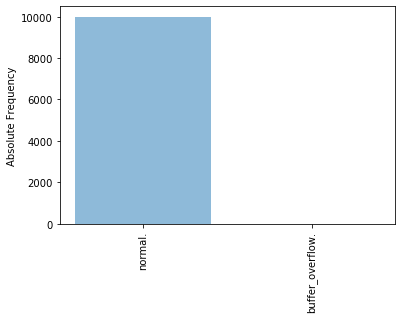

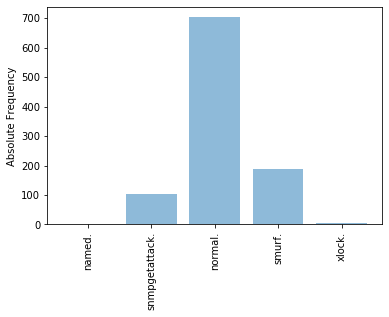

In [5]:
import numpy as np
from operator import add

ltr_threat = tr_threat.map(lambda x: x[0])
tr_threat  = tr_threat.map(lambda x: x[1])

lts_threat = ts_threat.map(lambda x: x[0])
ts_threat  = ts_threat.map(lambda x: x[1])

def descriptive_statistics(labelled_threat):
    threat_count = labelled_threat.map(lambda lt: (lt, 1)).reduceByKey(add).collect()
    
    threat_labels = list(map(lambda x: x[0], threat_count))
    threat_values = list(map(lambda x: x[1], threat_count))
    y_pos = np.arange(len(threat_labels))

    plt.bar(y_pos, threat_values, align='center', alpha=0.5)
    plt.xticks(y_pos, threat_labels, rotation=90)
    plt.ylabel("Absolute Frequency")
    plt.show()

    return zip(threat_labels, threat_values)

labels = [ lab[0][:-1] for lab in descriptive_statistics(ltr_threat) ]

_ = descriptive_statistics(lts_threat)

**Scaling characteristics to $\mu=0$ and $\delta=1$**

In [6]:
from pyspark.mllib.feature import StandardScaler

std = StandardScaler(withMean=True, withStd=True)
model = std.fit(tr_threat)

std_tr_threat = model.transform(tr_threat)
std_ts_threat = model.transform(ts_threat)

print("Train:", std_tr_threat.take(1))
print("Test:",  std_ts_threat.take(1))

Train: [DenseVector([-0.0349, -0.198, 3.8659, 0.0, 0.0, -0.01, -0.0907, 0.0, 0.2504, -0.014, -0.0283, -0.0141, -0.0135, -0.0214, -0.0141, -0.0371, 0.0, 0.0, -0.1093, -0.7925, -0.8653, -0.0587, -0.0596, 0.0, 0.0, 0.0828, -0.0829, -0.4651, -1.1016, -2.5515, -5.1268, -0.2638, -0.4303, -0.5242, -0.1213, -0.1292, 0.0, 0.0])]
Test: [DenseVector([-0.0349, -0.3315, -0.398, 0.0, 0.0, -0.01, -0.0907, 0.0, -3.9934, -0.014, -0.0283, -0.0141, -0.0135, -0.0214, -0.0141, -0.0371, 0.0, 0.0, -0.1093, -0.6723, -0.7616, -0.0587, -0.0596, 0.0, 0.0, 0.0828, -0.0829, -0.4651, 1.4066, 0.5638, 0.3285, -0.1164, -0.4303, -0.5242, -0.1213, -0.1292, 0.0, 0.0])]


**Preparation of binomial labels**

In [7]:
from pyspark.mllib.regression import LabeledPoint

std_train_data = ltr_threat.zip(std_tr_threat)
std_test_data  = lts_threat.zip(std_ts_threat)

std_train_data.take(1)

[('normal.',
  DenseVector([-0.0349, -0.198, 3.8659, 0.0, 0.0, -0.01, -0.0907, 0.0, 0.2504, -0.014, -0.0283, -0.0141, -0.0135, -0.0214, -0.0141, -0.0371, 0.0, 0.0, -0.1093, -0.7925, -0.8653, -0.0587, -0.0596, 0.0, 0.0, 0.0828, -0.0829, -0.4651, -1.1016, -2.5515, -5.1268, -0.2638, -0.4303, -0.5242, -0.1213, -0.1292, 0.0, 0.0]))]

In [8]:
def prepare_binary_classifier_data(label, data_vector):
    attack = 0 if label.find('normal') >= 0 else 1
    return LabeledPoint(attack, data_vector)

train_data = std_train_data.map(lambda x: prepare_binary_classifier_data(x[0], x[1]))
test_data  = std_test_data.map(lambda x:  prepare_binary_classifier_data(x[0], x[1]))

print(train_data.count())
print(train_data.take(20))

10000
[LabeledPoint(0.0, [-0.03486899095871041,-0.19803220930343252,3.8659241350436013,0.0,0.0,-0.01,-0.09066522725622919,0.0,0.25038567487959407,-0.01398365428880604,-0.028294176933755945,-0.014142842854277925,-0.013484514299615922,-0.021439818318327676,-0.014142842854277925,-0.03712073783854319,0.0,0.0,-0.1092689734600817,-0.7924850388604241,-0.8652529752378413,-0.05869689118084668,-0.059597451430428695,0.0,0.0,0.08278133964452801,-0.0829141719549872,-0.46514187636889087,-1.1016447409071435,-2.5515104669944386,-5.126823200442944,-0.2637935377475113,-0.4302509585418034,-0.5241644391710485,-0.12133703729068723,-0.12918839969992407,0.0,0.0]), LabeledPoint(0.0, [-0.03486899095871041,-0.2623309020546917,0.017866657655636078,0.0,0.0,-0.01,-0.09066522725622919,0.0,0.25038567487959407,-0.01398365428880604,-0.028294176933755945,-0.014142842854277925,-0.013484514299615922,-0.021439818318327676,-0.014142842854277925,-0.03712073783854319,0.0,0.0,-0.1092689734600817,-0.6723095810689,-0.7615764741

**Descriptive statistics on the labelled points of data, having been scaled and mapped.**

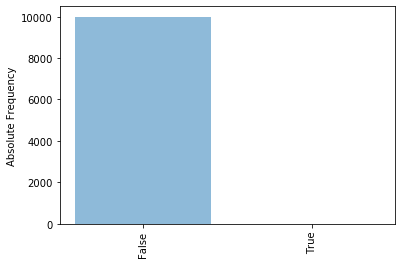

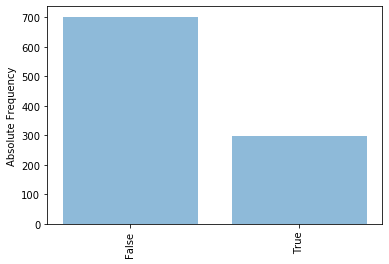

In [9]:
tr_threat  = train_data.map(lambda p: p.features)
ltr_threat = train_data.map(lambda p: p.label > 0)

ts_threat  = test_data.map(lambda p: p.features)
lts_threat = test_data.map(lambda p: p.label > 0)

_ = descriptive_statistics(ltr_threat)
_ = descriptive_statistics(lts_threat)

**Representation of the logistic function**

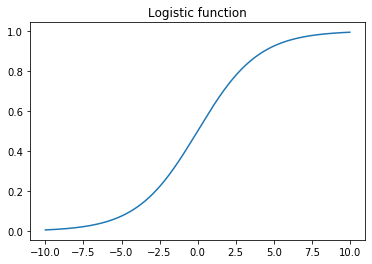

In [10]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, 1 / (1 + np.exp(-0.5 * x)))
plt.title("Logistic function")
plt.show()

**Modelling**

In [11]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

logistic_model = LogisticRegressionWithLBFGS.train(train_data, numClasses=2, intercept=False)

print(logistic_model.weights)

[-0.03460268904355921,-0.004053832977758575,-0.0019143978271271042,0.0,0.0,14.429444939032873,-0.0111356236091567,0.0,-0.010523510888308317,1204.7848041798088,0.024622931549425447,120.74092111868933,-1314.8177986979986,-15.7355544602584,0.0013922510026225107,-0.01985638785703415,0.0,0.0,0.0033597727501898356,-3.6571348921593454e-05,-0.007461544148021339,-0.5503719975162241,0.5349529739780441,0.0,0.0,0.15950758129026246,0.17614826159362992,0.004102797595426755,-0.004610053040372187,-0.0011194293619246828,0.012141263339120311,0.010788321281513368,-0.0009191648051305346,-0.013534126990377829,0.03842053189271451,-0.017026575338236084,0.0,0.0]


**Evaluating the model**

In [12]:
label_and_prediction = test_data.map(lambda p: (p.label, logistic_model.predict(p.features)))

def count_OK_vs_KO(value):
    real_value = value[0]
    predicted_value = value[1]

    result = 'OK' if real_value == predicted_value else 'KO'
    return (result, 1)

results = label_and_prediction.map(count_OK_vs_KO).reduceByKey(add).sortByKey(ascending=False).collect()

print(results)

[('OK', 698), ('KO', 302)]


In [13]:
def compute_error(results):
    results_matrix = {}
    results_matrix[results[0][0]] = results[0][1]
    results_matrix[results[1][0]] = results[1][1]

    error = float(results_matrix['KO']) * 100 / (float(results_matrix['OK']) + float(results_matrix['KO']))
    return error

error = compute_error(results)
print("Error: {}%".format(error, 2))

Error: 30.2%


In [14]:
from shutil import rmtree

path = "./LogisticBinomialModel"

try:
    rmtree(path)
except:
    pass

logistic_model.save(sc, path)

**Production-ready model**

In [15]:
logistic_model_prod = LogisticRegressionModel.load(sc, path)

**Confusion matrix from the binary classifier**

In [16]:
def count_confusion(values):
    real_value = values[0]
    predicted_value = values[1]
    return (str(int(real_value)) + '_' + str(int(predicted_value)), 1)

classification_result = label_and_prediction.map(count_confusion).reduceByKey(add).collect()
classification_result = np.sort(np.reshape(classification_result, (len(classification_result), 2)), axis=0)
print(classification_result)

[['0_0' '1']
 ['0_1' '296']
 ['1_0' '6']
 ['1_1' '697']]


In [17]:
def compute_absolute_freq_matrix(classification):
    num_classes = 2
    matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    for result in classification:
        c = [ int(r) for r in result[0].split('_') ]
        matrix[c[0], c[1]] = result[1]
    return matrix

abs_freq_matrix = compute_absolute_freq_matrix(classification_result)
print(abs_freq_matrix)

[[  1 296]
 [  6 697]]
